## 1. 패키지 불러오기

In [41]:
# 필요한 패키지 import
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

- OpenCV는 BGR 순서로 이미지를 저장하고 보여주지만, Maplotlib 등은 이미지를 RGB 순서대로 해석하고 출력한다.
- 그래서 OpenCV에서 불러온 이미지를 ```imshow()```로 출력하면 색이 뒤바뀌어 나오게 된다.

- 예를 들어, OpenCV로 불러온 이미지의 픽셀이 [255, 0, 0]일 때 Matplotlib에 그대로 넣으면 RGB로 해석하여 빨간색이 255만큼 있다고 인식하게 된다.

- 특히 얼굴 사진은 피부색에 빨간색 계열이 많기 때문에 RGB, BGR 따로 순서 처리를 해주지 않으면 파란 얼굴이 나온다.

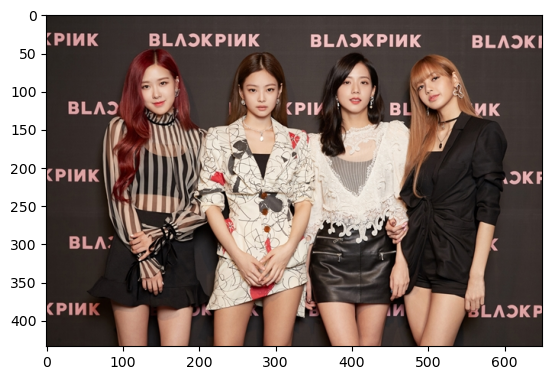

In [42]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/camera_sticker_project/블랙핑크.jpg') # 얼굴 이미지가 있는 경로

img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # OpenCV는 BGR 순서라 RGB 순서로 바꿔주기
plt.imshow(img_rgb) # 이미지를 실제 출력하기 위해 이미지를 올려줌 (실제 출력 X)
plt.show() # 이미지를 출력 (실제 출력)

## 2. dlib - hog dector

In [43]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [44]:
# 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(256, 84) (308, 136)], [(118, 78) (170, 130)], [(386, 79) (429, 122)], [(475, 67) (527, 118)]]


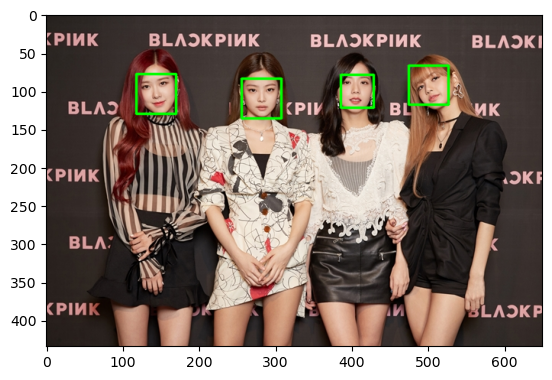

In [45]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. dlib landmark localization

In [46]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 ~/work/camera_sticker_project/models
!cd ~/work/camera_sticker_project && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2025-07-28 07:17:25--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-07-28 07:17:26--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.1MB/s    in 4.3s    

2025-07-28 07:17:31 (14.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [47]:
# 저장한 landmark 모델의 주소를 model_path 변수에 저장
model_path = os.path.join(home_dir, 'work/camera_sticker_project/models/shape_predictor_68_face_landmarks.dat')
    
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러오기
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle : 내부를 예측하는 박스
    # dlib.full_object_detection : 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [48]:
# 랜드마크의 위치를 저장할 list 생성
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냄
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


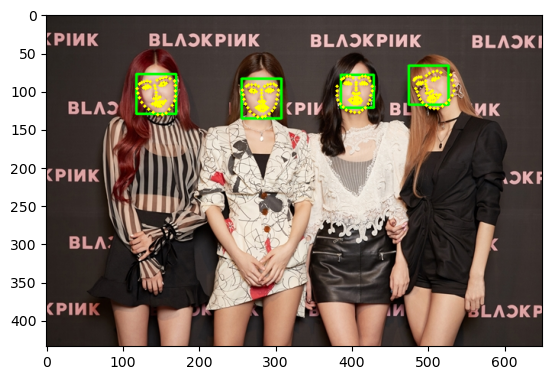

In [49]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

# RGB 이미지로 전환
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 이미지를 준비
plt.imshow(img_show_rgb)

# 이미지를 출력
plt.show()

- dlib의 shape_predictor_68_face_landmarks.dat 모델은 정면 얼굴에 최적화되어 있어, 측면/기울어진 얼굴에 약하다.
- ```detector(img, 0)```이 기본값이라 원본 해상도를 기준으로 얼굴을 탐지한다.
- 그러므로 ```detector(img_rgb, 2)```을 적용하여 이미지 크기를 업샘플링하여 얼굴을 더 정확하게 탐지하고자 했다.
- 이미지 해상도가 낮거나, 얼굴이 작거나, 옆을 보고 있을 때 얼굴을 더 잘 탐지할 수 있을 것이다. (물론 속도가 느려진다.)

In [50]:
# 랜드마크의 위치를 저장할 list 생성
list_landmarks = []

# 업샘플링 코드 추가
dlib_rects = detector_hog(img_rgb, 2)

# 얼굴 영역 박스 마다 face landmark를 찾아냄
# face landmark 좌표를 저장
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


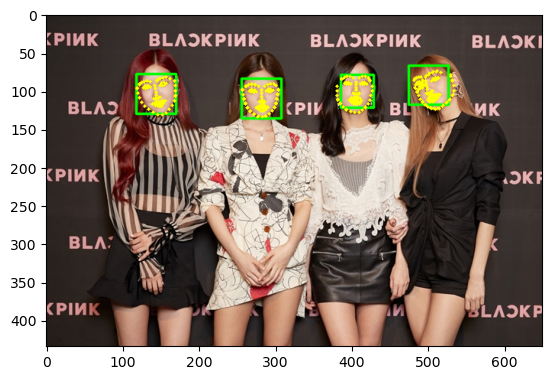

In [51]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

# RGB 이미지로 전환
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

# 이미지를 준비
plt.imshow(img_show_rgb)

# 이미지를 출력
plt.show()

- 업샘플링을 적용하니 조금 더 정확하게 인식할 수 있었다. (얼굴의 각도가 변화했을 때에도)
- 혹은 align 후에 다시 얼굴 인식을 하여 정밀한 랜드마크를 추출할 수 있다.
- 아래 실행한 align 방식은 실험 삼아 해본 것이라 참고용으로만 봐주시면 됩니다.

In [52]:
# 정렬 후 다시 얼굴 인식 → 정밀한 랜드마크 추출
#exp_aligned_faces = []
#exp_aligned_landmarks = []

#for i, face in enumerate(dlib_rects):
    # 1. 원본에서 랜드마크 추출
    #exp_shape = landmark_predictor(img_rgb, face)
    #exp_landmarks = [(p.x, p.y) for p in exp_shape.parts()]

    # 2. 얼굴 정렬
    #exp_aligned_img, _ = align_face_and_landmarks(img_rgb, exp_landmarks)

    # 3. 정렬된 얼굴에서 다시 얼굴 탐지
    #exp_new_faces = detector_hog(exp_aligned_img, 1)
    #if len(exp_new_faces) == 0:
        #continue

    # 4. 정렬된 얼굴에서 다시 랜드마크 추출
    #exp_new_shape = landmark_predictor(exp_aligned_img, exp_new_faces[0])
    #exp_new_landmarks = [(p.x, p.y) for p in exp_new_shape.parts()]

    #exp_aligned_faces.append(exp_aligned_img)
    #exp_aligned_landmarks.append(exp_new_landmarks)

# 시각화
#for face_img_exp, landmark_exp in zip(exp_aligned_faces, exp_aligned_landmarks):
     # 원본이 이미 RGB인 경우 (img_rgb에서 정렬된 결과라면)
    #exp_img_rgb = face_img_exp.copy()

    # RGB 이미지 기준으로 점 찍기 → matplotlib로 그대로 출력할 수 있게 유지
    #for (x, y) in landmark_exp:
        #cv2.circle(exp_img_rgb, (x, y), 2, (255, 255, 0), -1)

    #plt.figure(figsize=(4, 4))
    #plt.imshow(exp_img_rgb)
    #plt.title("Experiment: Aligned Face with Landmarks")
    #plt.axis("off")
    #plt.show()

## 4. 스티커 적용하기

- 참고로 for 문을 사용한 이유는 여러 명의 사람이 있을 때를 고려했다.
- 스티커 역시 다른 위치에 삽입할 것을 고려했었으나 코가 제일 자연스러운 것 같아 코로 설정했다.

In [53]:
# 스티커 경로
sticker_path = os.path.join(home_dir, 'work/camera_sticker_project/cat-whiskers.png')
original_sticker = cv2.imread(sticker_path) 

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()

    # Resize 스티커 (얼굴마다 크기 다르게)
    img_sticker = cv2.resize(original_sticker, (w, h), interpolation=cv2.INTER_AREA)
    print(f'Resized sticker shape: {img_sticker.shape}')

Resized sticker shape: (45, 45, 3)
Resized sticker shape: (55, 55, 3)
Resized sticker shape: (55, 55, 3)
Resized sticker shape: (55, 55, 3)


In [54]:
img_result = img_show.copy()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x, y = landmark[30] # 코가 제일 나은 것 같습니다..
    w = h = dlib_rect.width()

    x1 = x - w // 2
    y1 = y - int(h * 0.5)
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img_result.shape[1], x1 + w)
    y2 = min(img_result.shape[0], y1 + h)

    # 스티커 크기 리사이즈
    sticker_resized = cv2.resize(original_sticker, (x2 - x1, y2 - y1), interpolation=cv2.INTER_AREA)

    # 마스크 생성 : 흰색 배경 제거 (너무 밝은 픽셀만 제거)
    sticker_gray = cv2.cvtColor(sticker_resized, cv2.COLOR_BGR2GRAY)
    _, sticker_alpha = cv2.threshold(sticker_gray, 240, 255, cv2.THRESH_BINARY_INV)

    # 스티커 RGB 추출
    sticker_rgb = sticker_resized

    # 배경 합성
    roi = img_result[y1:y2, x1:x2]
    mask_inv = cv2.bitwise_not(sticker_alpha)
    bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    fg = cv2.bitwise_and(sticker_rgb, sticker_rgb, mask=sticker_alpha)

    dst = cv2.add(bg, fg)
    img_result[y1:y2, x1:x2] = dst

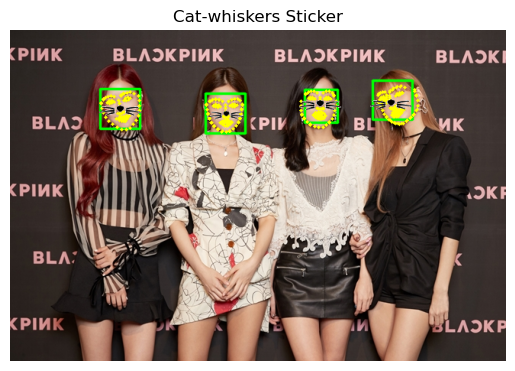

In [55]:
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Cat-whiskers Sticker")
plt.show()

- 잘 적용되는 것을 확인했으니 img_bgr을 사용해서 스티커만 남기기로 한다.
- 아래는 위와 같은 코드지만 함수화하여 좀 더 편리하게 사용할 수 있도록 했다.

In [56]:
img_final = img_bgr.copy()

def apply_sticker_on_copy(img, dlib_rect, landmark, sticker_img):
    x, y = landmark[30]  # 코 좌표
    w = h = dlib_rect.width()

    x1 = max(0, x - w // 2)
    y1 = max(0, y - int(h * 0.5))
    x2 = min(img.shape[1], x1 + w)
    y2 = min(img.shape[0], y1 + h)

    # 리사이즈
    sticker_resized = cv2.resize(sticker_img, (x2 - x1, y2 - y1), interpolation=cv2.INTER_AREA)

    # 흰 배경 마스크
    gray = cv2.cvtColor(sticker_resized, cv2.COLOR_BGR2GRAY)
    _, alpha_mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    mask_inv = cv2.bitwise_not(alpha_mask)
    mask_3ch = cv2.merge([alpha_mask, alpha_mask, alpha_mask])

    roi = img[y1:y2, x1:x2]
    bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
    fg = cv2.bitwise_and(sticker_resized, sticker_resized, mask=alpha_mask)

    img[y1:y2, x1:x2] = cv2.add(bg, fg)

In [57]:
# 원본 img_bgr은 그대로 놓고, 원복 복사를 img_final에 저장하고 스티커 붙임
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    apply_sticker_on_copy(img_final, dlib_rect, landmark, original_sticker)

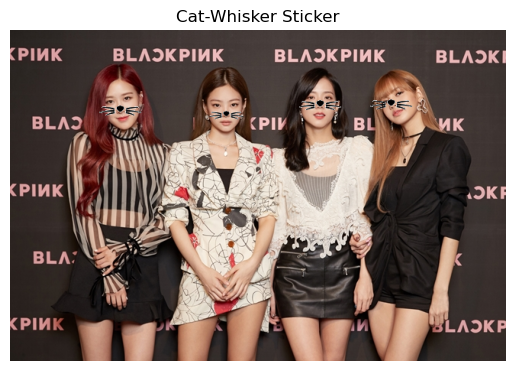

In [58]:
plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Cat-Whisker Sticker")
plt.show()

## 5. 실험
- 얼굴 각도가 돌아가 있으면 약간 정확도가 떨어져서 자연스럽지 않다.
- 양쪽 눈(landmark[36], landmark[45])의 좌표로 얼굴 기울기 각도를 계산한다.
- 해당 각도를 기준으로 스티커를 회전한다. (여기서 중요한 것은 방향을 반전해야 얼굴 각도에 맞는다!!)

In [90]:
def apply_cat_whisker(img, dlib_rect, landmark, sticker_img):
    # 기준점 : 코 아래
    x, y = landmark[33]
    w = h = dlib_rect.width()

    # 스티커 붙일 위치 좌표 계산
    x1 = max(0, x - w // 2)
    y1 = max(0, y - int(h * 0.5))  # 약간 위로 붙이기
    x2 = min(img.shape[1], x1 + w)
    y2 = min(img.shape[0], y1 + h)

    # 스티커 리사이즈
    sticker_resized = cv2.resize(sticker_img, (x2 - x1, y2 - y1), interpolation=cv2.INTER_AREA)

    # 회전 각도 계산 (눈의 y값 차이로)
    left_eye = landmark[36]
    right_eye = landmark[45]
    roll_angle = math.degrees(math.atan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]))
    roll_angle = -roll_angle  # OpenCV 기준, 방향 반전해야 얼굴 각도에 맞음

    # 스티커 회전
    center = (sticker_resized.shape[1] // 2, sticker_resized.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, roll_angle, 1.0)
    sticker_rotated = cv2.warpAffine(
        sticker_resized,
        rot_mat,
        (sticker_resized.shape[1], sticker_resized.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderValue=(255, 255, 255)  # 흰 배경 제거 대비
    )

    # 흰 배경 마스크 만들기 (밝은 부분 제거)
    sticker_gray = cv2.cvtColor(sticker_rotated, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(sticker_gray, 240, 255, cv2.THRESH_BINARY_INV)

    mask_3ch = cv2.merge([mask, mask, mask])
    roi = img[y1:y2, x1:x2]

    # 스티커와 원본 ROI 합성
    sticker_area = cv2.bitwise_and(sticker_rotated, mask_3ch)
    bg_area = cv2.bitwise_and(roi, cv2.bitwise_not(mask_3ch))
    blended = cv2.add(bg_area, sticker_area)

    # 이미지에 적용
    img[y1:y2, x1:x2] = blended

In [92]:
# img_bgr : 원본 이미지 (덮어씌울 대상)
# original_sticker : 스티커 이미지 (알파채널 없음, 흰 배경)
img_exp_angle = img_bgr.copy()

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    apply_cat_whisker(img_exp_angle, dlib_rect, landmark, original_sticker)

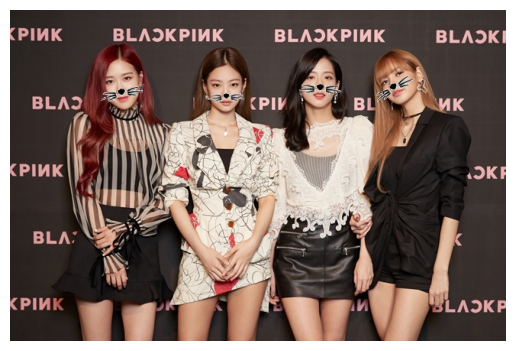

In [93]:
# 시각화
plt.imshow(cv2.cvtColor(img_exp_angle, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

## 6. 회고
- 증명사진에도 해보고 다 인원이 있는 사진에도 해봤는데 생각보다 고려해야 할 요소가 많아서 어려웠다.
- 메이크업의 경우에는 아이라인을 따라서 적용하면 되니까 조금 더 쉽지 않을까 생각이 들었던 거 같다.
- 여러 요인들을 고려해야 할 경우에는 어떤 요소를 반영할 것인지 더 많은 생각을 해야할 것 같다.
- 실험을 더 해보고 싶었는데 시간 부족으로 인해 더 하고 싶었는데 아쉬웠다. 근데 그래도 열심히 시도해 보면서 어느 정도 만족한다!